<a href="https://colab.research.google.com/github/yasirroni/HRV-Stress/blob/master/tf_b1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic text classification
source: https://www.tensorflow.org/tutorials/keras/classification

In [1]:
from IPython import get_ipython
get_ipython().magic('reset -f')

# Import library

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [3]:
print(tf.__version__)

2.4.1


## Download dataset

In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

84131840/84125825 [==============================] - 4s 0us/step


## Data overview

In [5]:
dataset # this is the file path where the downloaded file located

'./aclImdb_v1.tar.gz'

In [6]:
!pwd # this is the notebook root location

/content


In [7]:
os.getcwd() # this is the notebook root location

'/content'

In [8]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
dataset_dir # /content/aclImdb

'./aclImdb'

In [9]:
os.listdir(dataset_dir)

['train', 'test', 'README', 'imdb.vocab', 'imdbEr.txt']

In [10]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsup',
 'urls_unsup.txt',
 'pos',
 'urls_pos.txt',
 'neg',
 'labeledBow.feat',
 'unsupBow.feat',
 'urls_neg.txt']

In [11]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## Data preparation

In [12]:
# Prepare folder in the following format, delete other folder

# main_directory/
# ...class_a/
# ......a_text_1.txt
# ......a_text_2.txt
# ...class_b/
# ......b_text_1.txt
# ......b_text_2.txt

# feed to tf.keras.preprocessing.text_dataset_from_directory()
# create dataset with feature x and label y

In [13]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir) # delete an entire directory tree

In [14]:
# create train and validation data set from train
batch_size = 32 # batch size
seed = 42 # seed for splitting

# dataset train in batch
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed) # train and validation must be from a single dataset

# dataset validation in batch
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed) # train and validation must be from a single dataset

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [15]:
# test dataset doesneed to be shufled
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## Dataset (after preparation) overview

In [16]:
for text_batch, label_batch in raw_train_ds.take(1): # take 1 batch
    for i in range(3): # loop over 3 dataset from batch
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [17]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [18]:
# raw_train_ds.take(n) # take n-batch of dataset
# raw_train_ds.class_names[i] # see class name of data with label i
# raw_train_ds.map(lambda X, y:x) #map x,y to x, removing label

## Preprocessing

In [19]:
# custom standardization for preprocessing layer
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data) # make all lower
    stripped_html = tf.strings.regex_replace(lowercase, # remove html tag <br /> 
                                             '<br />', 
                                             ' ')
    return tf.strings.regex_replace(stripped_html, # remove punctuation
                                    '[%s]' % re.escape(string.punctuation),
                                    '')
    # s.translate(str.maketrans('', '', string.punctuation))

In [20]:
max_features = 10000 # max unique number of tokens
sequence_length = 250 # max sequence: truncate if over and pad if lower

# preprocessing layer (vectorize)
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [21]:
# make a text-only dataset (without labels), then call layer.adapt 
# must only use train
train_text = raw_train_ds.map(lambda x, y: x) # remove label
vectorize_layer.adapt(train_text) # adapt the preprocess layer

In [22]:
# # create function to vectorize dataset to vector of tokens
# def vectorize_text(text, label):
#     """
#     Since dataset is in (text, label) format, the input and output of the 
#     function must be identical.
#     """
#     text = tf.expand_dims(text, -1) # convert one text to batch of 1 text
#     return vectorize_layer(text), label

In [23]:
class CustomVectorizeFunction:
    """
    Class for converting layer into map function.
    """
    def __init__(self, layer):
       self.layer = layer

    def __call__(self, text, label):
        """
        Since dataset is in (text, label) format, the input and output of the 
        vectorize_text function must be identical.
        """
        text = tf.expand_dims(text, -1) # convert one text to batch of 1 text
        return self.layer(text), label

vectorize_text = CustomVectorizeFunction(vectorize_layer)

## Overview of vectorize layer

In [24]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds)) # retrive single batch
first_review, first_label = text_batch[0], label_batch[0] # take first data
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [25]:
# vectorize_layer outputs are vector with lenght of sequence_length of tokens
print("Vectorized review", vectorize_text(first_review, first_label))

Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1287,  313, 2380,  313,  661,    7,    2,   52,  229,    5,    2,
         200,    3,   38,  170,  669,   29, 5492,    6,    2,   83,  297,
         549,   32,  410,    3,    2,  186,   12,   29,    4,    1,  191,
         510,  549,    6,    2, 8229,  212,   46,  576,  175,  168,   20,
           1, 5361,  290,    4,    1,  761,  969,    1,    3,   24,  935,
        2271,  393,    7,    1, 1675,    4, 3747,  250,  148,    4,  112,
         436,  761, 3529,  548,    4, 3633,   31,    2, 1331,   28, 2096,
           3, 2912,    9,    6,  163,    4, 1006,   20,    2,    1,   15,
          85,   53,  147,    9,  292,   89,  959, 2314,  984,   27,  762,
           6,  959,    9,  564,   18,    7, 2140,   32,   24, 1254,   36,
           1,   85,    3, 3298,   85,    6, 1410,    3, 1936,    2, 3408,
         301,  965,    7,    4,  112,  740, 1977,   12,    1, 2014, 2772,
           3,    4,  428,    3, 5177,    6,  

In [26]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


## Preprocess train, validation, and test using preprocessing layer

In [27]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configure dataset for performance
Read more at: https://www.tensorflow.org/guide/data_performance

In [28]:
# cahce() to keeps data in memory after it's loaded off disk
# prefetch() to overlaps data preprocessing and model execution while training
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Build model

In [29]:
# Embedding layer used to find vector representation of each tokens
# GlobalAveragePooling1D used to averaging the vectors into single vector

embedding_dim = 16
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim), # tokens to vectors
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(), # averaging sequence of vectors 
    layers.Dropout(0.2),
    layers.Dense(1)]) # binary classification

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [30]:
# loss using binary cross entropy because the task is binary classification
loss_fn = losses.BinaryCrossentropy(from_logits=True)

model.compile(loss=loss_fn,
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## Train

In [31]:
# number of learning iteration
epochs = 10

# train model
# save model history to variable
history = model.fit( 
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 12s 15ms/step - loss: 0.6809 - binary_accuracy: 0.6188 - val_loss: 0.6138 - val_binary_accuracy: 0.7718
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5795 - binary_accuracy: 0.7816 - val_loss: 0.4989 - val_binary_accuracy: 0.8230
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4668 - binary_accuracy: 0.8341 - val_loss: 0.4207 - val_binary_accuracy: 0.8472
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3917 - binary_accuracy: 0.8602 - val_loss: 0.3740 - val_binary_accuracy: 0.8616
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3436 - binary_accuracy: 0.8774 - val_loss: 0.3450 - val_binary_accuracy: 0.8670
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3116 - binary_accuracy: 0.8874 - val_loss: 0.3257 - val_binary_accuracy: 0.8710
Epoch 7/10
625/625 [==============================] - 3s 5ms/s

## Evaluation

In [32]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.3102 - binary_accuracy: 0.8736
Loss:  0.31015297770500183
Accuracy:  0.8736400008201599


In [33]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

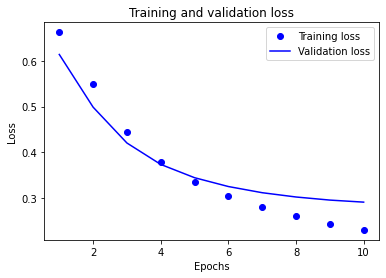

In [34]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

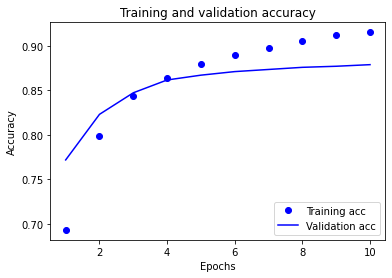

In [35]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Compile model for deployment (include preprocessing and sigmoid layer)

In [36]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid') # convert logits to probability
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=['accuracy']
)

In [37]:
# Test compiled model (including preprocessing) with `raw_test_ds`
# `raw_test_ds` yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3089 - accuracy: 0.8743
0.8736400008201599


In [38]:
# predict (probability)
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6292517 ],
       [0.4516487 ],
       [0.36883047]], dtype=float32)

In [39]:
# predict (class)
prediction = tf.round(export_model.predict(examples)) # using 0.5 as threshold
prediction

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[1.],
       [0.],
       [0.]], dtype=float32)>